In [8]:
import os
import numpy as np
import pandas as pd
import pickle
import quandl
from datetime import datetime
import time

Stock Market Prices

Looking at the stock market may provide clues as to how the general economy is performing, or even how specific industries are responding to the blockchain revolution.
This analysis scrapes yahoo finance and returns historical daily data. 

In [9]:
def get_stock_prices(market, market_name=None):

        """Retrieve the historical price (or value) of a publically listed stock or index

        

        Parameters

        ----------

        market : the code of the stock or index (see yahoo finance for examples)

            ('%5EDJI' refers to the Dow Jones and '%5EIXIC' pulls the Nasdaq index)

        market_name : specify an appropriate market name or label (under the market_name column)

            the default is None (default is None i.e. the column is not included)

            

        Returns

        -------

        pandas Dataframe

        

        Notes

        -----

        This method scrapes data from yahoo finance, so it only works when the historical

        data is presented on the site (which is not the case for a large number of stocks/indices).

        """

        from_date = int(time.mktime(time.strptime("2017-04-27", "%Y-%m-%d")))
        #print(from_date)

        # we want the daily data

        # this site works off unix time (86400 seconds = 1 day)

        to_date = int(time.mktime(time.strptime("2018-04-27", "%Y-%m-%d"))) + 86400
        
        url = "https://finance.yahoo.com/quote/{}/history?period1={}&period2={}&interval=1d&filter=history&frequency=1d".format(

        market, from_date,  to_date)
        
        #print(url)

        try: 

            parsed_page = urlopen(url, timeout=1).read()
            
            parsed_page = parsed_page.decode("utf8")

        except Exception as e:

            return pd.DataFrame({"error":e}, index=[0])

        start_segment = parsed_page.find('{\"prices\":')

        if start_segment != -1:

            start_list = parsed_page.find("[", start_segment)

            end_list = parsed_page.find("]", start_list)

            parsed_page = parsed_page[start_list:end_list+1]

        else:

            return pd.DataFrame({"error":"Could not find the appropriate text tag"}, index=[0])

        output = json.loads(parsed_page)

        output = pd.DataFrame(output)

        output['date'] = pd.to_datetime(output['date'],unit='s').apply(lambda x: x.date())

        output['date'] = pd.to_datetime(output['date'])

        if market_name is not None:

            output['market_name'] = market_name

        #output = merge_fill_filter(output)
        

        return output

In [10]:
def extract_coinmarketcap(coin, coin_col=False):

        """Retrieve basic historical information for a specific cryptocurrency from coinmarketcap.com

        

        Parameters

        ----------

        coin : the name of the cryptocurrency (e.g. 'bitcoin', 'ethereum', 'dentacoin')

        coin_col : whether to include the coin name as a column

            (default is False i.e. the column is not included)

            

        Returns

        -------

        pandas Dataframe

        """

        try:
            #print(self)
            #print(coin)
            #print(coin_col)
            from_date = "2017-04-27"
            to_date = "2018-04-27"
            output = pd.read_html("https://coinmarketcap.com/currencies/{}/historical-data/?start={}&end={}".format(
                coin, from_date.replace("-", ""), to_date.replace("-", "")))[0]
           # output= pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20170408&end=20180428")
                                 
        except Exception as e:

            return pd.DataFrame({"error":e}, index=[0])

        output = output.assign(Date=pd.to_datetime(output['Date']))

        for col in output.columns:

            if output[col].dtype == np.dtype('O'):

                output.loc[output[col]=="-",col]=0

                output[col] = output[col].astype('int64')

        output.columns = [col.lower() for col in output.columns]

        if coin_col:

            output['coin'] = coin

        return output

In [13]:
import pandas as pd
import urllib
from urllib.request import urlopen
import json
stocks_df = extract_coinmarketcap("bitcoin")[['date', 'close']].rename({'close':'Bitcoin'}, axis=1)
#print(stocks_df)
stock_codes = ['%5EDJI', 'AMD', 'NVDA', 'AMZN', 'GOOG', '%5EIXIC', 'JPM', 'INTC', 'KODK']
stock_names = ['Dow Jones', 'AMD', 'NVIDIA', 'Amazon', 'Google', 'Nasdaq', 'JP Morgan', 'Intel', 'Kodak']
for stock_code, stock_name in zip(stock_codes, stock_names):
    stocks_df = stocks_df.merge(
        get_stock_prices(stock_code)[['date', 'close']].rename(
            {'close':stock_name}, axis=1), on='date', how='inner')
stocks_df = stocks_df.dropna(axis=0, how='any')

In [14]:
stocks_df

,date,Bitcoin,Dow Jones,AMD,NVIDIA,Amazon,Google,Nasdaq,JP Morgan,Intel,Kodak
0,2018-04-27,8987.05,24311.189453,11.11,226.330002,1572.619995,1030.050049,7119.799805,109.400002,52.730000,5.10
1,2018-04-26,9281.51,24322.339844,11.04,225.220001,1517.959961,1040.040039,7118.680176,110.099998,53.049999,4.95
2,2018-04-25,8845.74,24083.830078,9.71,216.660004,1460.170044,1021.179993,7003.740234,109.989998,51.380001,4.95
3,2018-04-24,9697.50,24024.130859,10.09,221.199997,1460.089966,1019.979980,7007.350098,110.410004,51.450001,4.90
4,2018-04-23,8930.88,24448.689453,10.04,223.880005,1517.859985,1067.449951,7128.600098,110.930000,51.099998,4.85
5,2018-04-20,8845.83,24462.939453,9.99,228.710007,1527.489990,1072.959961,7146.129883,111.470001,51.529999,4.90
6,2018-04-19,8294.31,24664.890625,10.11,229.039993,1556.910034,1087.699951,7238.060059,111.720001,52.220001,4.90
7,2018-04-18,8163.42,24748.070312,10.36,236.369995,1527.839966,1072.079956,7295.240234,109.320000,53.610001,5.00
8,2018-04-17,7902.09,24786.630859,10.52,237.539993,1503.829956,1074.160034,7281.100098,110.209999,53.540001,5.05
9,2018-04-16,8058.67,24573.039062,10.09,231.490005,1441.500000,1037.979980,7156.279785,110.209999,52.400002,5.10


In [15]:
for col in stocks_df.columns:
    if col != 'date':
        stocks_df[col] = stocks_df[col]/stocks_df[col][-1:].values

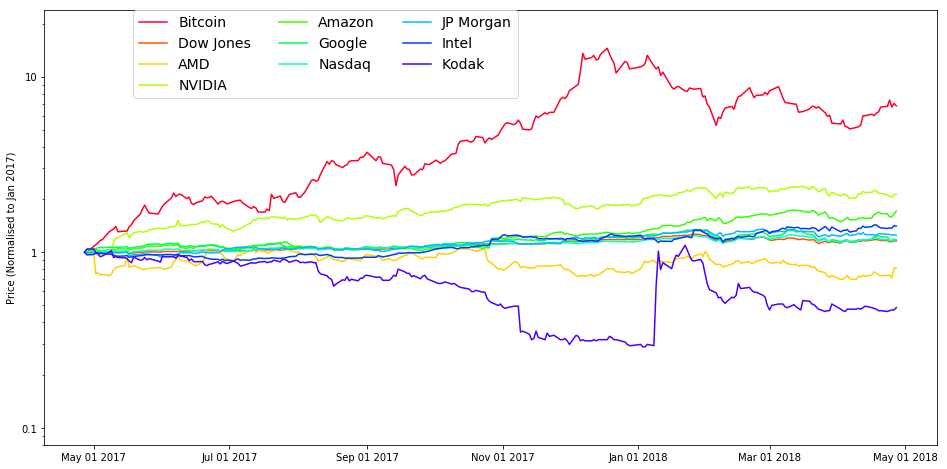

In [19]:
import datetime
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker
import numpy as np
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(1, 1, figsize=(16, 8))

cm = plt.get_cmap('gist_rainbow')

ax1.set_xticks([datetime.date(j,i,1) for i in range(1,13,2) for j in range(2017, 2019)])
ax1.set_xticklabels([datetime.date(j,i,1).strftime('%b %d %Y') 
                     for i in range(1,13,2) for j in range(2017, 2019)])
for stock_name, color in zip([col for col in stocks_df.columns if col != 'date'],
                             [cm(1.*i/len(stocks_df.columns)) for i in range(len(stocks_df.columns))]):
    ax1.plot(stocks_df['date'].astype(datetime.datetime), 
             stocks_df[stock_name], label=stock_name, color=color)
ax1.set_yscale('log')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: (
            '{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax1.set_ylabel('Price (Normalised to Jan 2017)')
ax1.set_ylim([0.08, 24])
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., ncol=3, prop={'size': 14})
plt.show()

This graph shows the return you would have received if you had invested on January 3rd. As Bitcoin went up the most (>10x returns), it was objectively the best investment.
As before, we can create a bitcoin stock market correlation plot.

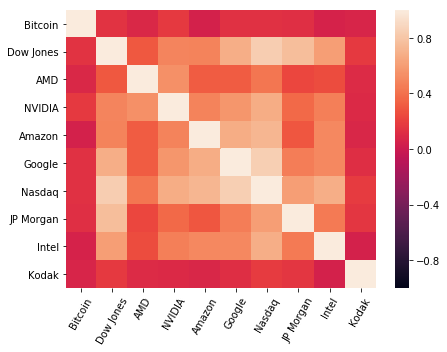

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# remove non-trading days from correlation analysis
plt.figure(figsize=(6.5, 5))
corr = get_stock_prices('%5EDJI').dropna()[['date']].merge(
    stocks_df, on = 'date', how='inner').drop(labels='date', axis=1).pct_change().corr(method='pearson')
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values,
            vmin=-1,  vmax=1)
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

In [21]:
corr

,Bitcoin,Dow Jones,AMD,NVIDIA,Amazon,Google,Nasdaq,JP Morgan,Intel,Kodak
Bitcoin,1.000000,0.144703,0.092039,0.177429,0.053577,0.138443,0.136728,0.129997,0.058363,0.075605
Dow Jones,0.144703,1.000000,0.299153,0.488522,0.476563,0.683080,0.839265,0.765617,0.604999,0.176856
AMD,0.092039,0.299153,1.000000,0.540017,0.314069,0.319014,0.425642,0.233456,0.255412,0.103326
NVIDIA,0.177429,0.488522,0.540017,1.000000,0.479166,0.569144,0.675728,0.367500,0.468641,0.100001
Amazon,0.053577,0.476563,0.314069,0.479166,1.000000,0.672297,0.723001,0.291148,0.502689,0.078667
Google,0.138443,0.683080,0.319014,0.569144,0.672297,1.000000,0.850125,0.455677,0.505010,0.120273
Nasdaq,0.136728,0.839265,0.425642,0.675728,0.723001,0.850125,1.000000,0.607684,0.684494,0.181023
JP Morgan,0.129997,0.765617,0.233456,0.367500,0.291148,0.455677,0.607684,1.000000,0.443653,0.162892
Intel,0.058363,0.604999,0.255412,0.468641,0.502689,0.505010,0.684494,0.443653,1.000000,0.053238
Kodak,0.075605,0.176856,0.103326,0.100001,0.078667,0.120273,0.181023,0.162892,0.053238,1.000000


The highest correlation recorded (0.85) is between Google and Nasdaq, which is not surprising, as the former is large component of the latter. As for Bitcoin, it was most correlated with Google (0.138), but its relationship with the stock market was generally quite weak.